# Цифра

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Цель проекта:**

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

## Подготовка данных

### Изучение данных

#### Библиотеки

In [110]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from numpy.random import RandomState
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, make_scorer 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

Убрираем длинные циферки. Трех знаков после запятой будет достаточно.

In [111]:
pd.set_option('display.float_format', '{:,.5f}'.format)

Отключаем лишние предупреждения.

In [112]:
import warnings
warnings.filterwarnings('ignore')

#### Функции

Все функции используемые в проекте тут:

##### column_differences

In [113]:
class gold_recovery:
    
    def column_differences(self, df1, df2):
        '''
        Функция находит отличия по столбцам между df1 и df2
        и выводит список столбцов имеющиеся только в df1
        '''
        df1_columns = df1.columns
        df2_columns = df2.columns
        differences = df1_columns.difference(df2_columns)
        counter = 0
        print('========== Отличающиеся столбцы ==========\n')
        for i in differences:
            counter += 1
            print("{}. {}".format(counter, i))
        if counter == 0:
            print('Отсутствуют!')
        print('\nКоличество столбцов в df1:', len(df1_columns))
        print('Количество столбцов в df2:', len(df2_columns))
        print('Общее количество отличающихся столбцов: ', counter)


##### column_values

In [114]:
def column_values(data_frame):
    '''
    Функция для визуального поиска артефактов и выбросов в значениях DataFrame
    '''
    for column in data_frame.columns:
        print('\nЗначения столбца', column,':')
        print(data_frame[column].sort_values().unique())
        '''
        display(data_frame[column].hist(bins=100))
        plt.title("Распределение", column,':')
        plt.show()
        display(ax = sns.boxplot(data = data_frame,
                                 x = column,
                                 orient = 'h'))
        plt.title("Распределение значений", column,':')
        plt.show()
        '''

##### df_info

In [115]:
def df_info(data_frame):
    '''
    Функция выводящая первичную информацию о DataFrame
    '''
    print('\nРазмер таблицы: {} '.format(data_frame.shape))
    print('\nИнфо:')
    print(data_frame.info())                                            # сколько значений и в каком формате
    print('\nПропусков:')
    print(data_frame.isna().mean().sort_values(ascending=False) * 100)  # подсчёт пропусков в процентах
    print('\ndescribe:')
    display(data_frame.describe())                                      # вдруг чего "на глазок" проявится 
    print('\nДубликатов =', data_frame.duplicated().sum())              # проверим дубликаты

##### drop_0_from_column

In [116]:
def drop_0_from_column(data_frame, column):
    '''
    Функция удаляет "0" в заданном столбце
    '''
    data_frame = data_frame.drop(data_frame[data_frame[column] == 0].index)
    print(data_frame[data_frame[column] == 0].shape)

##### final_smape

In [117]:
def final_smape(model_1, model_2, 
                features1, target1, 
                features2, target2, 
                params):
    '''
    Функция для анализа модели и расчета итогового sMape
    '''
    score = make_scorer(smape, greater_is_better = False)
    grid_1 = GridSearchCV(model_1, 
                          params, 
                          scoring = score, 
                          cv = 5, 
                          n_jobs = -1)                            # кроссвалидация для rougher
    grid_1.fit(features1, target1)
    smape_rougher = (-1) * grid_1.best_score_
    print('\nsMAPE rougher: {:.2f}%'. format(smape_rougher))
    print('Лучшие параметры rougher:', grid_1.best_params_)
    grid_2 = GridSearchCV(model_2, 
                          params, 
                          scoring = score, 
                          cv = 5, 
                          n_jobs = -1)                            # кроссвалидация для final
    grid_2.fit(features2, target2)
    smape_final = (-1) * grid_2.best_score_
    print('\nsMAPE final: {:.2f}%'. format(smape_final))
    print('Лучшие параметры final:', grid_2.best_params_)
    final_smape = 0.25*smape_rougher + 0.75*smape_final                    # расчет итогового sMAPE
    print ('\nИтоговое sMAPE: {:.2f}%\n'. format(final_smape))
    return final_smape

##### percentage_of_nan

In [118]:
def percentage_of_nan(data_frame):
    '''
    Функция для визуализации количества пропусков в процентах
    '''
    columns = data_frame.columns.values.tolist()
    nan = []

    for col in columns:
      not_nan_count = data_frame[col].count()
      percent = ((len(data_frame) - not_nan_count) / len(data_frame)) * 100
      nan.append(percent)

    nan_percent_before = pd.Series(nan,
                                   index = columns)
    nan_percent_before_mean = nan_percent_before.mean()
    nan_percent_before.sort_values(ascending = True,
                                   inplace = True)

    fig, ax = plt.subplots(figsize = (12,18))
    ax.barh(nan_percent_before.index,
            nan_percent_before.values)
    ax.set_title('Процент пропусков значений по столбцам')

    # Добавим на график цифры значений
    for i in ax.patches:
      plt.text(i.get_width()+0.5,
               i.get_y()+0.2,
               str(round(i.get_width(),1)),
               fontsize = 10,
               fontweight = 'bold',
               color = 'black')
    # Построим линию, показывающую средний % пропусков по столбцам
    plt.axvline(x = nan_percent_before_mean,
                linewidth = 2,
                label = 'Средний % пропусков по столбцам = {}'.format(round(nan_percent_before_mean, 1)),
                color = 'r',
                linestyle = '--')
    plt.legend()
    plt.show()

##### print_plot и print_bar_metal

In [119]:
def print_plot(df, stage):
    '''
    1.1. Вывод диаграммы среднего количетсва металлов на каждом этапе обработки
    '''
    print()
    df.plot(kind = 'bar')
    plt.title('Среднее содержание металла на каждом этапе (в '+ stage +')')
    plt.xlabel('Этап обработки')
    plt.ylabel('средняя концентрация металла')
    plt.xticks(np.arange(4),
               df['steps'])
    plt.rc('axes',
           titlesize = 16)
    plt.rc('axes',
           labelsize = 10)
    plt.xticks(rotation = 30)
    plt.show()


    
def print_bar_metal(data):
    '''
    1.2. Вывод диаграммы среднего количетсва металлов на каждом этапе обработки
    '''
    processing_step = ['rougher.input',
                       'rougher.output',
                       'primary_cleaner.output',
                       'final.output']
    df_concentrate = pd.DataFrame({'steps':processing_step})
    df_tail = pd.DataFrame({'steps':processing_step})
    for metal in metals:
        data_means_concentrate = [data['rougher.input.feed_' + metal[0]].mean(),
                                  data['rougher.output.concentrate_' + metal[0]].mean(),
                                  data['primary_cleaner.output.concentrate_' + metal[0]].mean(),
                                  data['final.output.concentrate_' + metal[0]].mean()] 
        data_means_tail = [data['rougher.input.feed_' + metal[0]].mean(),
                           data['rougher.output.tail_' + metal[0]].mean(),
                           data['primary_cleaner.output.tail_' + metal[0]].mean(),
                           data['final.output.tail_' + metal[0]].mean()]
        df_concentrate[metal] = data_means_concentrate
        df_tail[metal] = data_means_tail
    print_plot(df_concentrate,'чистом концентрате')
    print_plot(df_tail,'отвальных хвостах')

##### smape

In [120]:
def smape(target, predict):
    '''
    Функция расчета метрики качества sMAPE 
    (симметричное среднее абсолютное процентное отклонение)
    '''
    smape = (-1) * ((1/len(target)) * 
             sum(2 * abs(target - predict) / 
                 (abs(target) + abs(predict)))) * 100
    return smape

In [121]:
gr = gold_recovery()

Читаем файл с данными и сохраняем в df.

In [122]:
try:
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv',
                           index_col = 'date',  # Столбец 'date' убираем в индекс.
                           parse_dates = ['date'])
except:
    ! gdown --id 1SAlACtg21CTotDMQkIufa2vUSv3u8cUF
    df_train = pd.read_csv('/content/gold_recovery_train_new.csv',
                           index_col = 'date',
                           parse_dates = ['date'])

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1SAlACtg21CTotDMQkIufa2vUSv3u8cUF
To: /content/gold_recovery_train_new.csv
100% 22.8M/22.8M [00:00<00:00, 178MB/s]


In [123]:
try:
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv',
                          index_col = 'date', 
                          parse_dates = ['date'])
except:
    ! gdown --id 13w3HIq7AMv48LtsklcJqDkGFZnAukpVH
    df_test = pd.read_csv('/content/gold_recovery_test_new.csv',
                          index_col = 'date', 
                          parse_dates = ['date'])

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=13w3HIq7AMv48LtsklcJqDkGFZnAukpVH
To: /content/gold_recovery_test_new.csv
100% 5.27M/5.27M [00:00<00:00, 229MB/s]


In [124]:
try:
    df_full= pd.read_csv('/datasets/gold_recovery_full_new.csv',
                         index_col = 'date',
                         parse_dates = ['date'])
except:
    ! gdown --id 1M5iEZf4bvgP0Rzw2KpviwG2kWIoKbdlN
    df_full = pd.read_csv('/content/gold_recovery_full_new.csv',
                          index_col = 'date',
                          parse_dates = ['date'])

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1M5iEZf4bvgP0Rzw2KpviwG2kWIoKbdlN
To: /content/gold_recovery_full_new.csv
100% 31.3M/31.3M [00:00<00:00, 193MB/s]


#### Таблица df_train

In [125]:
display(df_train.columns)
print()
display(df_train)

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.05540,9.88965,5.50732,42.19202,70.54122,10.41196,0.89545,16.90430,2.14315,127.09200,...,14.01684,-502.48801,12.09993,-504.71594,9.92563,-498.31021,8.07967,-500.47098,14.15134,-605.84198
2016-01-15 01:00:00,6.02937,9.96894,5.25778,42.70163,69.26620,10.46268,0.92745,16.63451,2.22493,125.62923,...,13.99228,-505.50326,11.95053,-501.33153,10.03925,-500.16998,7.98476,-500.58217,13.99835,-599.78718
2016-01-15 02:00:00,6.05593,10.21399,5.38376,42.65750,68.11645,10.50705,0.95372,16.20885,2.25789,123.81981,...,14.01502,-502.52090,11.91278,-501.13338,10.07091,-500.12913,8.01388,-500.51757,14.02866,-601.42736
2016-01-15 03:00:00,6.04798,9.97702,4.85863,42.68982,68.34754,10.42276,0.88376,16.53283,2.14685,122.27019,...,14.03651,-500.85731,11.99955,-501.19369,9.97037,-499.20164,7.97732,-500.25591,14.00555,-599.99613
2016-01-15 04:00:00,6.14860,10.14251,4.93942,42.77414,66.92702,10.36030,0.79283,16.52569,2.05529,117.98817,...,14.02730,-499.83863,11.95307,-501.05389,9.92571,-501.68673,7.89424,-500.35603,13.99665,-601.49669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-18 06:59:59,3.22492,11.35623,6.80348,46.71395,73.75515,8.76965,3.14154,10.40318,1.52922,123.38179,...,23.03150,-501.16794,20.00757,-499.74003,18.00604,-499.83437,13.00111,-500.15569,20.00784,-501.29643
2018-08-18 07:59:59,3.19598,11.34935,6.86225,46.86678,69.04929,8.89732,3.13049,10.54947,1.61254,120.87819,...,22.96009,-501.61278,20.03566,-500.25136,17.99853,-500.39518,12.95405,-499.89516,19.96850,-501.04161
2018-08-18 08:59:59,3.11000,11.43437,6.88601,46.79569,67.00219,8.52961,2.91142,11.11515,1.59662,105.66612,...,23.01572,-501.71160,19.95123,-499.85703,18.01954,-500.45116,13.02343,-499.91439,19.99089,-501.51845


Посмотрим заполненость таблицы df_train.


Размер таблицы: (14149, 86) 

Инфо:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   fina

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,"14,148.00000","14,148.00000","13,938.00000","14,149.00000","14,149.00000","14,149.00000","14,049.00000","14,144.00000","14,149.00000","14,129.00000",...,"14,143.00000","14,148.00000","14,148.00000","14,148.00000","14,148.00000","14,148.00000","14,148.00000","14,148.00000","14,147.00000","14,148.00000"
mean,5.14203,10.13296,9.20285,44.00379,66.51883,9.60703,2.59730,10.51212,2.91842,133.32066,...,19.98545,-478.69684,15.48707,-460.22942,16.77514,-483.95602,13.06459,-483.96656,19.57754,-506.79848
std,1.36959,1.65493,2.79052,4.90526,10.29540,2.31907,0.97184,3.00362,0.90371,39.43166,...,5.65772,50.73602,5.25565,58.84359,5.83191,37.89279,5.76562,39.20791,5.76442,37.07925
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00311,...,0.00000,-799.70907,0.00000,-799.88911,-0.37205,-797.14247,0.64621,-800.00618,0.19532,-809.39867
25%,4.21162,9.29735,7.48465,43.27611,62.54582,7.99743,1.90597,8.81132,2.36861,107.00665,...,14.99078,-500.62866,11.89456,-500.14900,11.08398,-500.36318,8.99440,-500.10599,14.98930,-500.74510
50%,4.99465,10.29714,8.84546,44.87244,67.43278,9.48027,2.59202,10.51462,2.85103,133.01833,...,20.00179,-499.68145,14.97554,-499.38874,17.93222,-499.70245,11.99755,-499.91456,19.98418,-500.06143
75%,5.85954,11.17060,10.48751,46.16642,72.34643,11.00371,3.24172,11.93301,3.43476,159.82540,...,24.99083,-477.47241,20.05937,-400.03901,21.34655,-487.71211,17.98290,-453.18694,24.99162,-499.53647
max,16.00195,17.03190,18.12485,52.75664,100.00000,19.55215,5.63957,22.31773,8.19741,250.12783,...,30.11574,-245.23918,24.00791,-145.07109,43.70993,-275.07313,27.92600,-157.39607,32.18891,-104.42746



Дубликатов = 0



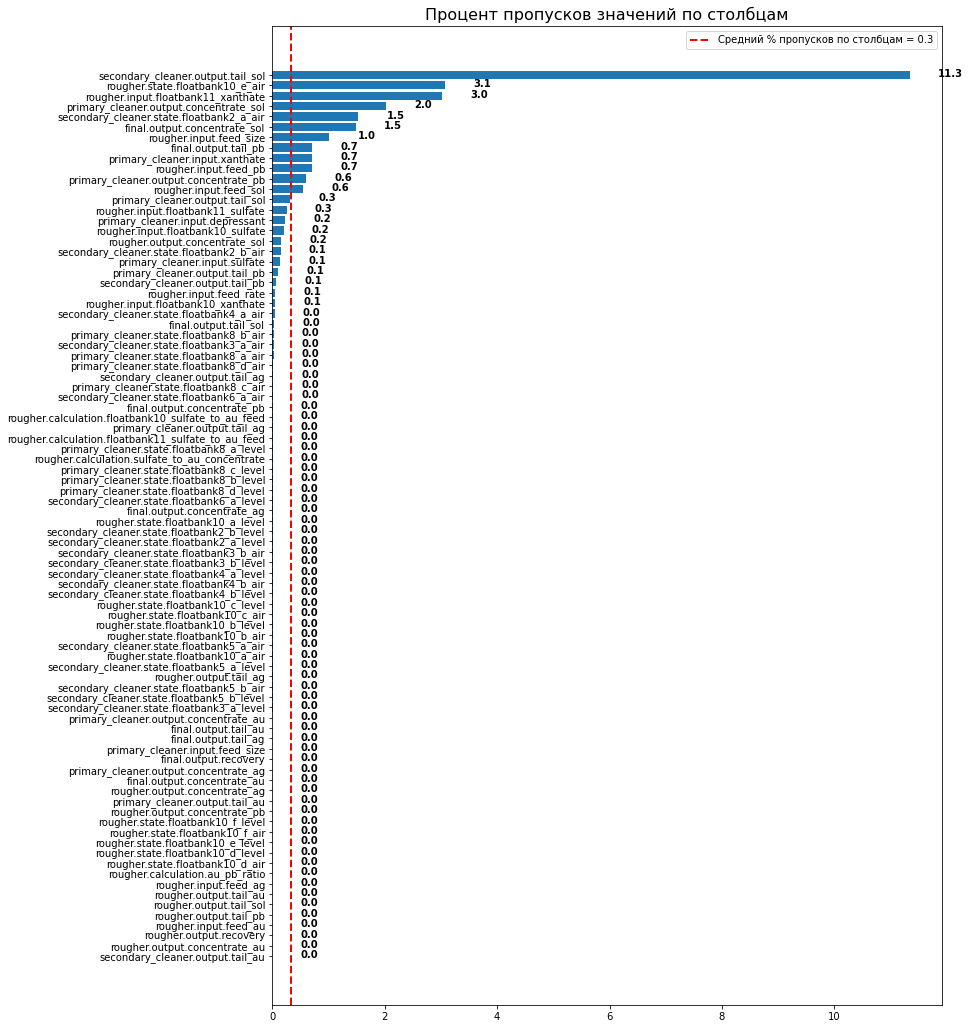

In [126]:
with pd.option_context('display.max_rows', None):
    df_info(df_train)
    print()
    percentage_of_nan(df_train)

Отлавливаем артефакты в данных.

In [127]:
column_values(df_train)


Значения столбца final.output.concentrate_ag :
[0.00000000e+00 9.99999978e-03 2.89058560e-01 ... 1.36916988e+01
 1.60019451e+01            nan]

Значения столбца final.output.concentrate_pb :
[0.00000000e+00 9.99999978e-03 3.32391277e-01 ... 1.67052966e+01
 1.70318995e+01            nan]

Значения столбца final.output.concentrate_sol :
[0.00000000e+00 9.99999978e-03 2.53230694e-01 ... 1.80463950e+01
 1.81248509e+01            nan]

Значения столбца final.output.concentrate_au :
[0.00000000e+00 9.99999978e-03 1.06399152e+00 ... 5.15718847e+01
 5.26817252e+01 5.27566376e+01]

Значения столбца final.output.recovery :
[  0.           0.16861094   0.43026371 ...  99.74147843  99.9101831
 100.        ]

Значения столбца final.output.tail_ag :
[0.00000000e+00 1.67896355e-02 8.06744246e-02 ... 1.91534636e+01
 1.91572238e+01 1.95521486e+01]

Значения столбца final.output.tail_pb :
[0.00000000e+00 4.50822342e-03 1.87642594e-02 ... 5.63815440e+00
 5.63956503e+00            nan]

Значения столбца

Посмотрим корреляцию значений столбцов друг с другом.

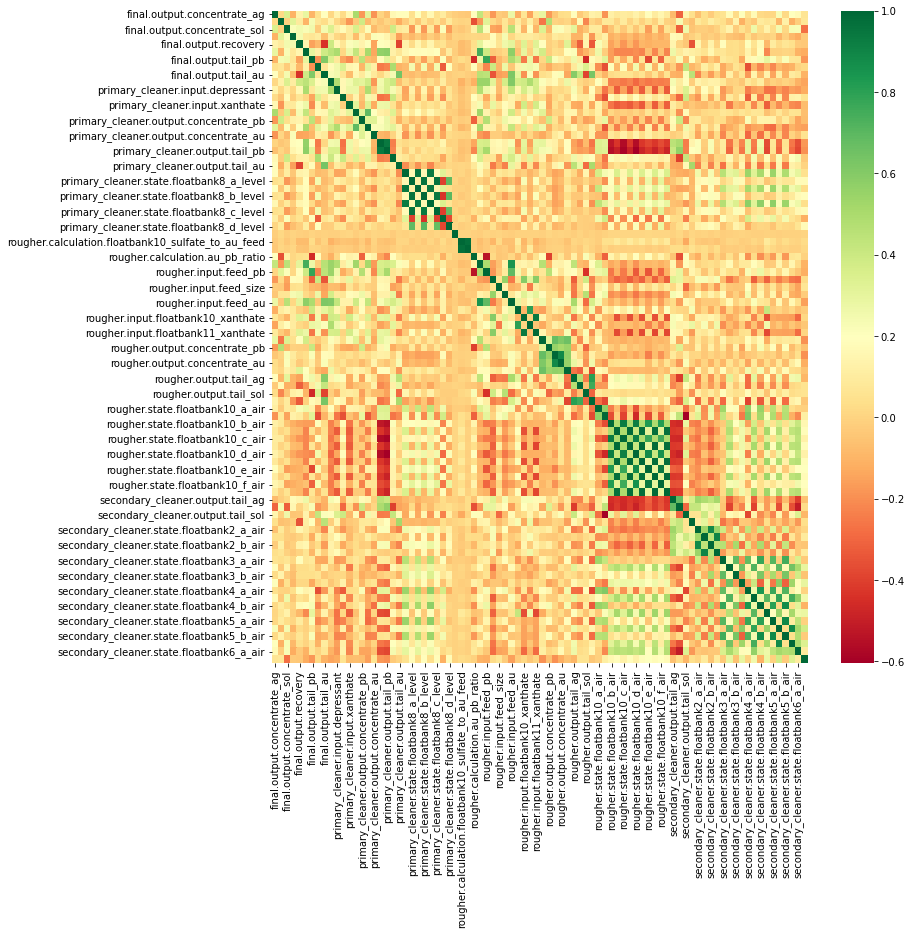

In [128]:
plt.figure(figsize = (12,12))
sns.heatmap(df_train.corr(),
            #annot=True,
            cmap='RdYlGn',
            fmt='.2f')
plt.show()

#### Таблица df_test

In [129]:
display(df_test.columns)
print()
display(df_test)

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatba

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.80091,14.99312,8.08000,1.00502,"1,398.98130",-500.22558,"1,399.14493",-499.91973,"1,400.10300",-500.70437,...,12.02355,-497.79583,8.01666,-501.28914,7.94656,-432.31785,4.87251,-500.03744,26.70589,-499.70941
2016-09-01 01:59:59,215.39245,14.98747,8.08000,0.99047,"1,398.77791",-500.05743,"1,398.05536",-499.77818,"1,396.15103",-499.24017,...,12.05814,-498.69577,8.13098,-499.63421,7.95827,-525.83965,4.87885,-500.16238,25.01994,-499.81944
2016-09-01 02:59:59,215.25995,12.88493,7.78667,0.99604,"1,398.49367",-500.86836,"1,398.86044",-499.76453,"1,398.07571",-502.15151,...,11.96237,-498.76748,8.09689,-500.82742,8.07106,-500.80167,4.90512,-499.82851,24.99486,-500.62256
2016-09-01 03:59:59,215.33624,12.00681,7.64000,0.86351,"1,399.61811",-498.86357,"1,397.44012",-499.21102,"1,400.12930",-498.35587,...,12.03309,-498.35093,8.07495,-499.47441,7.89708,-500.86851,4.93140,-499.96362,24.94892,-498.70999
2016-09-01 04:59:59,199.09933,10.68253,7.53000,0.80558,"1,401.26812",-500.80830,"1,398.12882",-499.50454,"1,402.17223",-500.81061,...,12.02537,-500.78650,8.05468,-500.39750,8.10789,-509.52672,4.95767,-500.36003,25.00333,-500.85633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:59:59,173.95776,15.96340,8.07000,0.89670,"1,401.93055",-499.72885,"1,401.44145",-499.19342,"1,399.81031",-499.59913,...,13.99596,-500.15745,12.06916,-499.67328,7.97726,-499.51613,5.93332,-499.96597,8.98717,-499.75591
2017-12-31 20:59:59,172.91027,16.00260,8.07000,0.89652,"1,447.07572",-494.71682,"1,448.85189",-465.96303,"1,443.89042",-503.58774,...,16.74978,-496.03154,13.36537,-499.12272,9.28855,-496.89297,7.37290,-499.94296,8.98683,-499.90376
2017-12-31 21:59:59,171.13572,15.99367,8.07000,1.16600,"1,498.83618",-501.77040,"1,499.57235",-495.51635,"1,502.74921",-520.66744,...,19.99413,-499.79131,15.10142,-499.93625,10.98918,-498.34790,9.02094,-500.04045,8.98204,-497.78988


Посмотрим заполненость таблицы df_test.


Размер таблицы: (5290, 52) 

Инфо:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_clean

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,"5,286.00000","5,285.00000","5,290.00000","5,286.00000","5,290.00000","5,290.00000","5,290.00000","5,290.00000","5,290.00000","5,290.00000",...,"5,290.00000","5,290.00000","5,290.00000","5,290.00000","5,290.00000","5,290.00000","5,290.00000","5,290.00000","5,290.00000","5,290.00000"
mean,174.83965,8.68360,7.26634,1.38380,"1,539.49433",-497.66588,"1,545.17423",-500.27310,"1,527.27236",-498.33068,...,16.32007,-505.14457,13.73544,-463.34986,12.80419,-501.32912,9.88114,-495.66340,17.30493,-501.79319
std,43.02708,3.07205,0.61022,0.64347,116.79788,19.95243,122.22459,32.96831,122.53803,21.96488,...,3.49358,31.42734,3.43048,86.18911,3.02659,17.95150,2.86820,34.53501,4.53654,39.04422
min,2.56616,0.00384,5.65000,0.00498,0.00000,-795.31634,0.00000,-799.99702,0.00000,-799.96057,...,0.00000,-799.79852,0.00000,-800.83691,0.06923,-797.32399,0.52808,-800.22034,-0.07943,-809.74146
25%,147.12140,6.48955,6.89000,0.90762,"1,498.93580",-500.35730,"1,498.97099",-500.70300,"1,473.22986",-501.01812,...,14.03618,-500.86826,12.02862,-500.32303,10.91484,-500.72684,8.03672,-500.19467,13.99732,-500.69098
50%,177.82849,8.05221,7.25000,1.19761,"1,585.12912",-499.96916,"1,595.62180",-500.02851,"1,549.59468",-500.01771,...,17.00847,-500.11573,14.96486,-499.57651,12.95418,-499.99033,10.00430,-499.99054,16.01493,-500.00713
75%,208.12544,10.02776,7.60000,1.79782,"1,602.07653",-499.56895,"1,602.32355",-499.29326,"1,601.14378",-498.99413,...,18.03862,-499.40422,15.96213,-400.93380,15.09753,-499.28319,11.99747,-499.71991,21.02001,-499.37302
max,265.98312,40.00000,15.50000,4.10245,"2,103.10358",-57.19540,"1,813.08367",-142.52723,"1,715.05377",-150.93703,...,30.05180,-401.56521,31.26971,-6.50699,25.25885,-244.48357,14.08687,-137.74000,26.70589,-123.30749



Дубликатов = 0



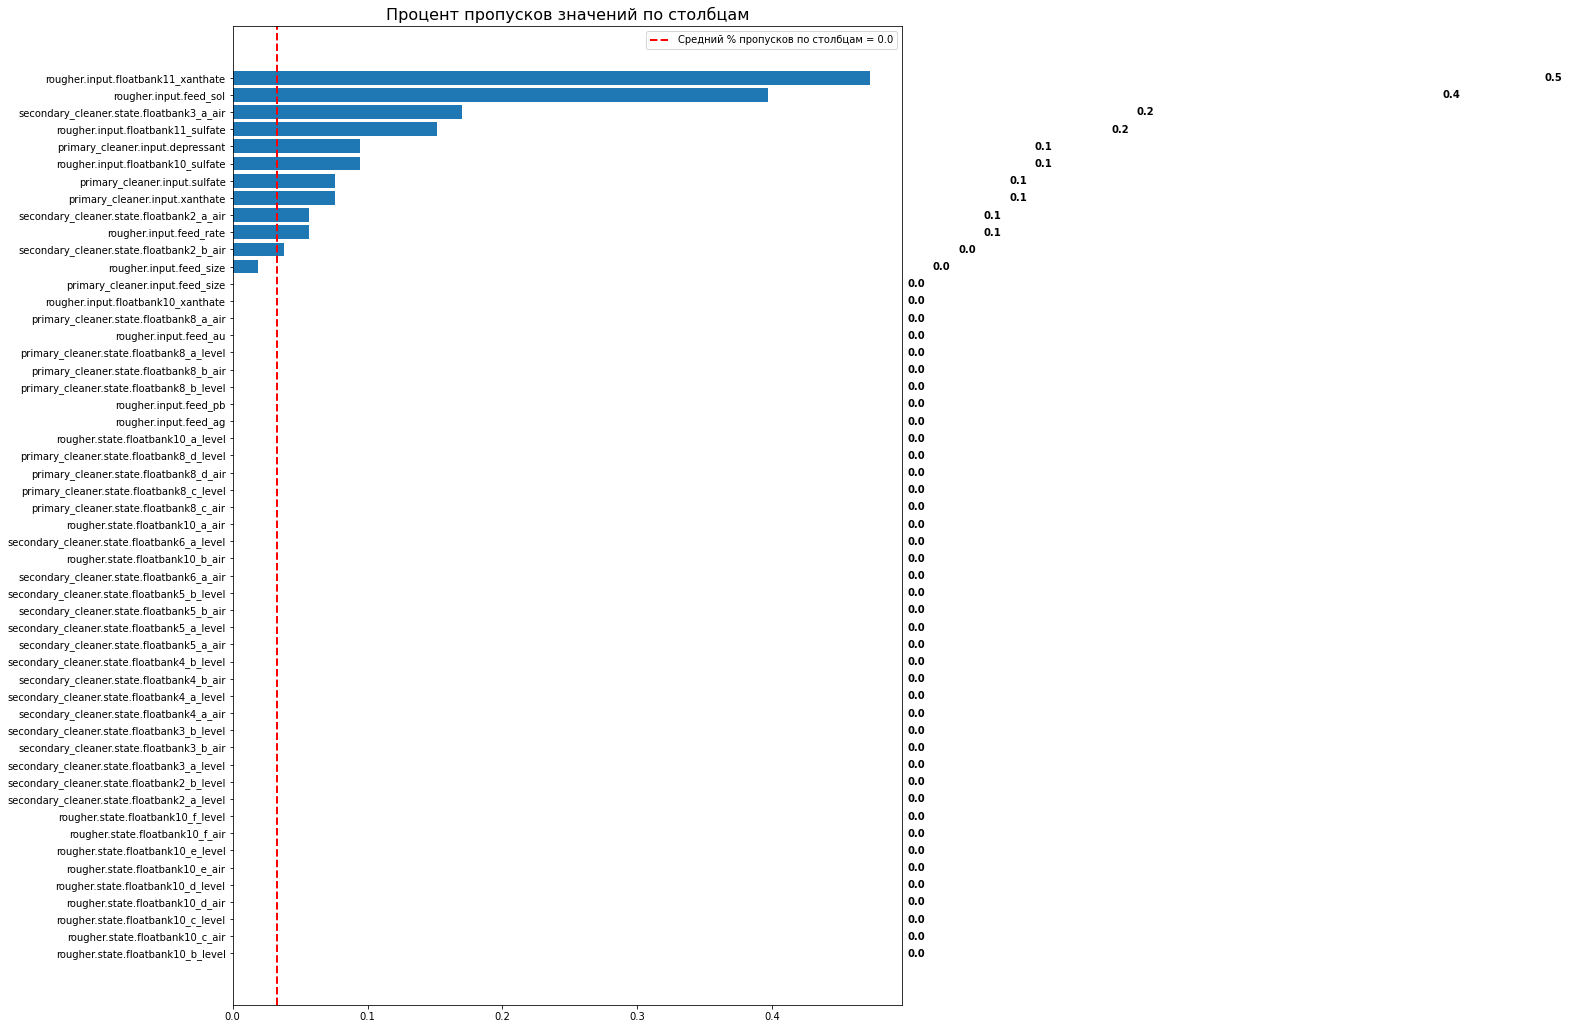

In [130]:
with pd.option_context('display.max_rows', None):
    df_info(df_test)
    print()
    percentage_of_nan(df_test)

Отлавливаем артефакты в данных.

In [131]:
column_values(df_test)


Значения столбца primary_cleaner.input.sulfate :
[  2.56615646   2.92672026   7.02559127 ... 262.53150186 265.98312306
          nan]

Значения столбца primary_cleaner.input.depressant :
[3.83948202e-03 5.73826182e-02 6.18642857e-02 ... 2.00467642e+01
 4.00000000e+01            nan]

Значения столбца primary_cleaner.input.feed_size :
[ 5.6500001   5.65000116  5.75       ...  9.77000046 11.47000792
 15.5       ]

Значения столбца primary_cleaner.input.xanthate :
[0.00498367 0.01048647 0.01804044 ... 4.06838427 4.10245436        nan]

Значения столбца primary_cleaner.state.floatbank8_a_air :
[5.44586042e-32 7.80587376e-32 4.12629243e+02 ... 1.92748500e+03
 2.09861546e+03 2.10310358e+03]

Значения столбца primary_cleaner.state.floatbank8_a_level :
[-795.31633745 -783.44855072 -782.5052678  ... -282.98844344 -189.69687804
  -57.19540358]

Значения столбца primary_cleaner.state.floatbank8_b_air :
[6.64749035e-32 9.52824100e-32 4.13703253e+02 ... 1.80640626e+03
 1.80944912e+03 1.81308367e+0

Посмотрим корреляцию значений столбцов друг с другом.

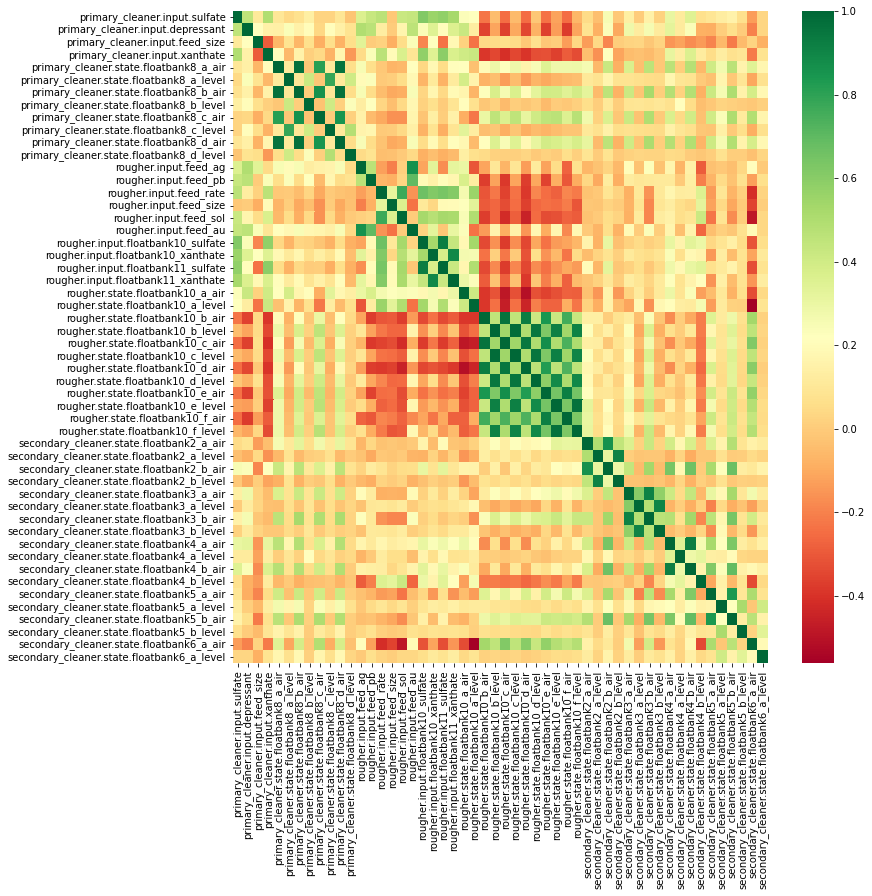

In [132]:
plt.figure(figsize = (12,12))
sns.heatmap(df_test.corr(),
            #annot = True,
            cmap = 'RdYlGn',
            fmt = '.2f')
plt.show()

#### Таблица df_full

In [133]:
display(df_full.columns)
print()
display(df_full)

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.05540,9.88965,5.50732,42.19202,70.54122,10.41196,0.89545,16.90430,2.14315,127.09200,...,14.01684,-502.48801,12.09993,-504.71594,9.92563,-498.31021,8.07967,-500.47098,14.15134,-605.84198
2016-01-15 01:00:00,6.02937,9.96894,5.25778,42.70163,69.26620,10.46268,0.92745,16.63451,2.22493,125.62923,...,13.99228,-505.50326,11.95053,-501.33153,10.03925,-500.16998,7.98476,-500.58217,13.99835,-599.78718
2016-01-15 02:00:00,6.05593,10.21399,5.38376,42.65750,68.11645,10.50705,0.95372,16.20885,2.25789,123.81981,...,14.01502,-502.52090,11.91278,-501.13338,10.07091,-500.12913,8.01388,-500.51757,14.02866,-601.42736
2016-01-15 03:00:00,6.04798,9.97702,4.85863,42.68982,68.34754,10.42276,0.88376,16.53283,2.14685,122.27019,...,14.03651,-500.85731,11.99955,-501.19369,9.97037,-499.20164,7.97732,-500.25591,14.00555,-599.99613
2016-01-15 04:00:00,6.14860,10.14251,4.93942,42.77414,66.92702,10.36030,0.79283,16.52569,2.05529,117.98817,...,14.02730,-499.83863,11.95307,-501.05389,9.92571,-501.68673,7.89424,-500.35603,13.99665,-601.49669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-18 06:59:59,3.22492,11.35623,6.80348,46.71395,73.75515,8.76965,3.14154,10.40318,1.52922,123.38179,...,23.03150,-501.16794,20.00757,-499.74003,18.00604,-499.83437,13.00111,-500.15569,20.00784,-501.29643
2018-08-18 07:59:59,3.19598,11.34935,6.86225,46.86678,69.04929,8.89732,3.13049,10.54947,1.61254,120.87819,...,22.96009,-501.61278,20.03566,-500.25136,17.99853,-500.39518,12.95405,-499.89516,19.96850,-501.04161
2018-08-18 08:59:59,3.11000,11.43437,6.88601,46.79569,67.00219,8.52961,2.91142,11.11515,1.59662,105.66612,...,23.01572,-501.71160,19.95123,-499.85703,18.01954,-500.45116,13.02343,-499.91439,19.99089,-501.51845


Посмотрим заполненость таблицы df_full.


Размер таблицы: (19439, 86) 

Инфо:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   fina

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,"19,438.00000","19,438.00000","19,228.00000","19,439.00000","19,439.00000","19,438.00000","19,338.00000","19,433.00000","19,439.00000","19,415.00000",...,"19,433.00000","19,438.00000","19,438.00000","19,438.00000","19,438.00000","19,438.00000","19,438.00000","19,438.00000","19,437.00000","19,438.00000"
mean,5.16847,9.97889,9.50122,44.07651,67.05021,9.68859,2.70580,10.58373,3.04247,144.62477,...,18.98767,-485.89452,15.01037,-461.07864,15.69445,-488.68407,12.19822,-487.14983,18.95902,-505.43630
std,1.37235,1.66924,2.78754,5.12978,10.12584,2.32864,0.94908,2.86878,0.92281,44.46407,...,5.41106,47.75857,4.89023,67.40552,5.51097,34.53340,5.33302,38.34731,5.55050,37.68906
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00311,...,0.00000,-799.79852,0.00000,-800.83691,-0.37205,-797.32399,0.52808,-800.22034,-0.07943,-809.74146
25%,4.25124,9.13726,7.72282,43.40221,63.29971,8.06288,2.04012,8.93895,2.46114,114.10703,...,14.97573,-500.70489,11.94029,-500.18774,10.98861,-500.45847,8.97111,-500.12946,14.98304,-500.72807
50%,5.06609,10.10243,9.21896,45.01124,68.17274,9.74362,2.74873,10.62246,2.98491,143.23210,...,18.01748,-499.83779,14.97101,-499.45979,15.00004,-499.80260,11.01943,-499.93532,19.96054,-500.04840
75%,5.89553,11.03577,10.94781,46.27531,72.68664,11.13429,3.33322,12.10427,3.57135,175.07566,...,23.01247,-498.24973,19.03416,-400.11811,18.02619,-498.38419,14.01909,-499.43671,24.00317,-499.49538
max,16.00195,17.03190,19.61572,52.75664,100.00000,19.55215,5.80418,22.31773,8.24502,265.98312,...,30.11574,-245.23918,31.26971,-6.50699,43.70993,-244.48357,27.92600,-137.74000,32.18891,-104.42746



Дубликатов = 0



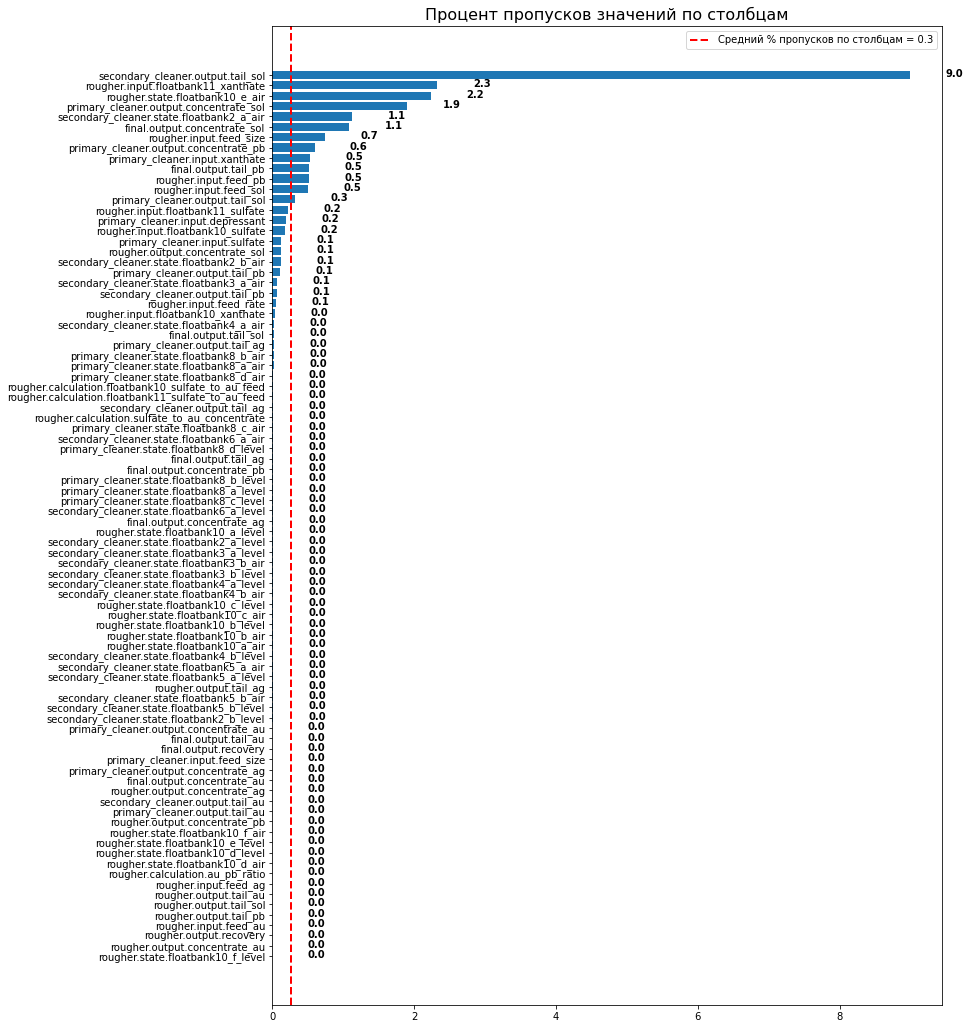

In [134]:
with pd.option_context('display.max_rows', None):
    df_info(df_full)
    print()
    percentage_of_nan(df_full)

Отлавливаем артефакты в данных.

In [135]:
column_values(df_full)


Значения столбца final.output.concentrate_ag :
[0.00000000e+00 9.99999978e-03 1.93950451e-01 ... 1.36916988e+01
 1.60019451e+01            nan]

Значения столбца final.output.concentrate_pb :
[0.00000000e+00 9.99999978e-03 3.32391277e-01 ... 1.67052966e+01
 1.70318995e+01            nan]

Значения столбца final.output.concentrate_sol :
[0.00000000e+00 9.99999978e-03 2.53230694e-01 ... 1.94239117e+01
 1.96157205e+01            nan]

Значения столбца final.output.concentrate_au :
[0.00000000e+00 9.99999978e-03 9.04253877e-01 ... 5.15718847e+01
 5.26817252e+01 5.27566376e+01]

Значения столбца final.output.recovery :
[  0.           0.16861094   0.43026371 ...  99.78398229  99.9101831
 100.        ]

Значения столбца final.output.tail_ag :
[0.00000000e+00 1.67896355e-02 7.84052873e-02 ... 1.91572238e+01
 1.95521486e+01            nan]

Значения столбца final.output.tail_pb :
[0.00000000e+00 4.50822342e-03 1.87642594e-02 ... 5.78673247e+00
 5.80417769e+00            nan]

Значения столбца

Посмотрим корреляцию значений столбцов друг с другом.

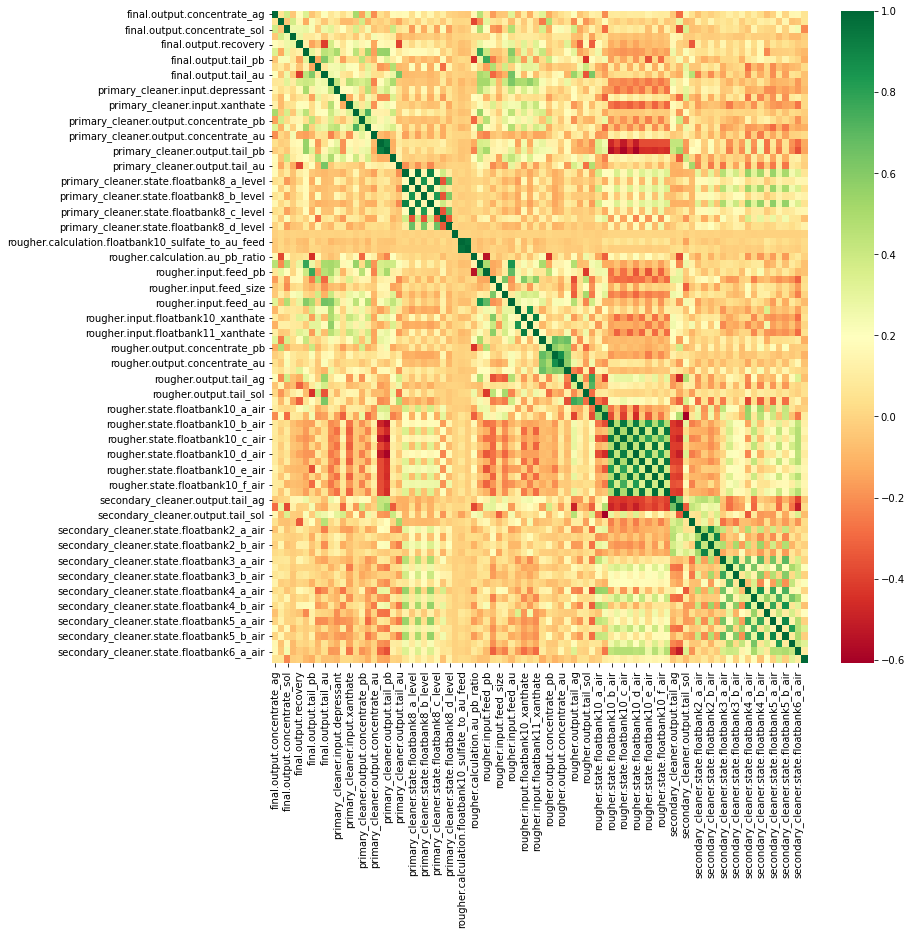

In [136]:
plt.figure(figsize = (12,12))
sns.heatmap(df_full.corr(),
            #annot = True,
            cmap = 'RdYlGn',
            fmt = '.2f')
plt.show()

Проверим, что в df_full строк столько же как и в остальных вместе взятых.

In [137]:
print('\nЗначений в df_full =', df_full.shape[0])
print('Значений в df_train + df_test =', df_train.shape[0] + df_test.shape[0])
print()


Значений в df_full = 19439
Значений в df_train + df_test = 19439



#### Вывод

Имеем всего 19439 значения.
14149 на обучающей выборке и 5290 на тестовой.

Есть уйма единичных пропусков на уровне 0,005-0,325%.

Дубликатов нет.

В значениях есть пропуски, но аномалий не наблюдается.


### Описание данных

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

Cтадии:

    1. Флотация
    Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», 
	то есть остатки продукта с низкой концентрацией ценных металлов.
    На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых 
	частиц и жидкости).

    2. Очистка
    Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

#### Технологический процесс

	• Rougher feed — исходное сырье
	• Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
		○ Xanthate **— ксантогенат (промотер, или активатор флотации);
		○ Sulphate — сульфат (на данном производстве сульфид натрия);
		○ Depressant — депрессант (силикат натрия).
	• Rougher process (англ. «грубый процесс») — флотация
	• Rougher tails — отвальные хвосты
	• Float banks — флотационная установка
	• Cleaner process — очистка
	• Rougher Au — черновой концентрат золота
	• Final Au — финальный концентрат золота

#### Параметры этапов

	• air amount — объём воздуха
	• fluid levels — уровень жидкости
	• feed size — размер гранул сырья
	• feed rate — скорость подачи

#### Наименование признаков

Наименование признаков должно быть такое:

[этап].[тип_параметра].[название_параметра]

Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:

	• rougher — флотация
	• primary_cleaner — первичная очистка
	• secondary_cleaner — вторичная очистка
	• final — финальные характеристики

Возможные значения для блока [тип_параметра]:

	• input — параметры сырья
	• output — параметры продукта
	• state — параметры, характеризующие текущее состояние этапа
	• calculation — расчётные характеристики

#### Названия столбцов

    final.output.concentrate_ag                          финальный.выход.серебро
    final.output.concentrate_pb                          финальный.выход.свинец
    final.output.concentrate_sol                         финальный.выход.соли
    final.output.concentrate_au                          финальный.выход.золото
    final.output.recovery                                финальный.выход.восстановление
    final.output.tail_ag                                 финальный.выход.отвал.серебро
    final.output.tail_pb                                 финальный.выход.отвал.свинец
    final.output.tail_sol                                финальный.выход.отвал.соли
    final.output.tail_au                                 финальный.выход.отвал.золото
    primary_cleaner.input.sulfate                        первичный.вход.сульфат
    primary_cleaner.input.depressant                     первичный.вход.депрессант
    primary_cleaner.input.feed_size                      первичный.вход.размер_гранул
    primary_cleaner.input.xanthate                       первичный.вход.ксантогенат
    primary_cleaner.output.concentrate_ag                первичный.выход.серебро
    primary_cleaner.output.concentrate_pb                первичный.выход.свинец
    primary_cleaner.output.concentrate_sol               первичный.выход.соли
    primary_cleaner.output.concentrate_au                первичный.выход.золото
    primary_cleaner.output.tail_ag                       первичный.выход.отвал.серебро
    primary_cleaner.output.tail_pb                       первичный.выход.отвал.свинец
    primary_cleaner.output.tail_sol                      первичный.выход.отвал.соли
    primary_cleaner.output.tail_au                       первичный.выход.отвал.золото
    primary_cleaner.state.floatbank8_a_air               первичный.параметры.установка_8_a_воздух
    primary_cleaner.state.floatbank8_a_level             первичный.параметры.установка_8_a_жидкость
    primary_cleaner.state.floatbank8_b_air               первичный.параметры.установка_8_b_воздух
    primary_cleaner.state.floatbank8_b_level             первичный.параметры.установка_8_b_жидкость
    primary_cleaner.state.floatbank8_c_air               первичный.параметры.установка_8_c_воздух
    primary_cleaner.state.floatbank8_c_level             первичный.параметры.установка_8_c_жидкость
    primary_cleaner.state.floatbank8_d_air               первичный.параметры.установка_8_d_воздух
    primary_cleaner.state.floatbank8_d_level             первичный.параметры.установка_8_d_жидкость
    rougher.calculation.sulfate_to_au_concentrate        черновой.расчётный.сульфат_золото
    rougher.calculation.floatbank10_sulfate_to_au_feed   черновой.расчётный.установка_10_подача_сульфат_золото
    rougher.calculation.floatbank11_sulfate_to_au_feed   черновой.расчётный.установка_11_подача_сульфат_золото
    rougher.calculation.au_pb_ratio                      черновой.расчётный.золото_свинец
    rougher.input.feed_ag                                черновой.вход.подача_серебро
    rougher.input.feed_pb                                черновой.вход.подача_свинец
    rougher.input.feed_rate                              черновой.вход.скорость_подачи
    rougher.input.feed_size                              черновой.вход.размер_гранул
    rougher.input.feed_sol                               черновой.вход.подача_солей
    rougher.input.feed_au                                черновой.вход.подача_золота
    rougher.input.floatbank10_sulfate                    черновой.вход.установка_10_сульфат
    rougher.input.floatbank10_xanthate                   черновой.вход.установка_10_ксантогенат
    rougher.input.floatbank11_sulfate                    черновой.вход.установка_11_сульфат
    rougher.input.floatbank11_xanthate                   черновой.вход.установка_11_ксантогенат
    rougher.output.concentrate_ag                        черновой.выход.серебро
    rougher.output.concentrate_pb                        черновой.выход.свинец
    rougher.output.concentrate_sol                       черновой.выход.соли
    rougher.output.concentrate_au                        черновой.выход.золото
    rougher.output.recovery                              черновой.выход.восстановление
    rougher.output.tail_ag                               черновой.выход.отвал.серебро
    rougher.output.tail_pb                               черновой.выход.отвал.свинец
    rougher.output.tail_sol                              черновой.выход.отвал.соли
    rougher.output.tail_au                               черновой.выход.отвал.золото
    rougher.state.floatbank10_a_air                      черновой.параметры.установка_10_a_воздух
    rougher.state.floatbank10_a_level                    черновой.параметры.установка_10_a_жидкость
    rougher.state.floatbank10_b_air                      черновой.параметры.установка_10_b_воздух
    rougher.state.floatbank10_b_level                    черновой.параметры.установка_10_b_жидкость
    rougher.state.floatbank10_c_air                      черновой.параметры.установка_10_c_воздух
    rougher.state.floatbank10_c_level                    черновой.параметры.установка_10_c_жидкость
    rougher.state.floatbank10_d_air                      черновой.параметры.установка_10_d_воздух
    rougher.state.floatbank10_d_level                    черновой.параметры.установка_10_d_жидкость
    rougher.state.floatbank10_e_air                      черновой.параметры.установка_10_e_воздух
    rougher.state.floatbank10_e_level                    черновой.параметры.установка_10_e_жидкость
    rougher.state.floatbank10_f_air                      черновой.параметры.установка_10_f_воздух
    rougher.state.floatbank10_f_level                    черновой.параметры.установка_10_f_жидкость
    secondary_cleaner.output.tail_ag                     вторичный.выход.отвал.серебро
    secondary_cleaner.output.tail_pb                     вторичный.выход.отвал.свинец
    secondary_cleaner.output.tail_sol                    вторичный.выход.отвал.соли
    secondary_cleaner.output.tail_au                     вторичный.выход.отвал.золото
    secondary_cleaner.state.floatbank2_a_air             вторичный.параметры.установка_2_a_воздух
    secondary_cleaner.state.floatbank2_a_level           вторичный.параметры.установка_2_a_жидкость
    secondary_cleaner.state.floatbank2_b_air             вторичный.параметры.установка_2_b_воздух
    secondary_cleaner.state.floatbank2_b_level           вторичный.параметры.установка_2_b_жидкость
    secondary_cleaner.state.floatbank3_a_air             вторичный.параметры.установка_3_a_воздух
    secondary_cleaner.state.floatbank3_a_level           вторичный.параметры.установка_3_a_жидкость
    secondary_cleaner.state.floatbank3_b_air             вторичный.параметры.установка_3_b_воздух
    secondary_cleaner.state.floatbank3_b_level           вторичный.параметры.установка_3_b_жидкость
    secondary_cleaner.state.floatbank4_a_air             вторичный.параметры.установка_4_a_воздух
    secondary_cleaner.state.floatbank4_a_level           вторичный.параметры.установка_4_a_жидкость
    secondary_cleaner.state.floatbank4_b_air             вторичный.параметры.установка_4_b_воздух
    secondary_cleaner.state.floatbank4_b_level           вторичный.параметры.установка_4_b_жидкость
    secondary_cleaner.state.floatbank5_a_air             вторичный.параметры.установка_5_a_воздух
    secondary_cleaner.state.floatbank5_a_level           вторичный.параметры.установка_5_a_жидкость
    secondary_cleaner.state.floatbank5_b_air             вторичный.параметры.установка_5_b_воздух
    secondary_cleaner.state.floatbank5_b_level           вторичный.параметры.установка_5_b_жидкость
    secondary_cleaner.state.floatbank6_a_air             вторичный.параметры.установка_6_a_воздух
    secondary_cleaner.state.floatbank6_a_level           вторичный.параметры.установка_6_a_жидкость

### Проверка эффективности обогащения

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery.

In [138]:
df_train['rougher.calculation.output.recovery'] = df_train['rougher.output.concentrate_au'
                                                          ] * (df_train['rougher.input.feed_au'] - df_train['rougher.output.tail_au']
                                                              ) / df_train['rougher.input.feed_au'
                                                                          ] / (df_train['rougher.output.concentrate_au'] - df_train['rougher.output.tail_au']
                                                                              ) * 100

Посмотрим что получилось:

In [139]:
print('\nАбсолютная средняя ошибка (MAE) = ', mean_absolute_error(df_train['rougher.output.recovery'], 
                                                                  df_train['rougher.calculation.output.recovery']))
print('\nclass labels = {}'.format(df_train.loc[:, ['rougher.output.recovery',
                                                    'rougher.calculation.output.recovery']
                                                ]))


Абсолютная средняя ошибка (MAE) =  1.0748911125799084e-14

class labels =                      rougher.output.recovery  \
date                                           
2016-01-15 00:00:00                 87.10776   
2016-01-15 01:00:00                 86.84326   
2016-01-15 02:00:00                 86.84231   
2016-01-15 03:00:00                 87.22643   
2016-01-15 04:00:00                 86.68879   
...                                      ...   
2018-08-18 06:59:59                 89.57438   
2018-08-18 07:59:59                 87.72401   
2018-08-18 08:59:59                 88.89058   
2018-08-18 09:59:59                 89.85813   
2018-08-18 10:59:59                 89.51496   

                     rougher.calculation.output.recovery  
date                                                      
2016-01-15 00:00:00                             87.10776  
2016-01-15 01:00:00                             86.84326  
2016-01-15 02:00:00                             86.84231  
2016-

#### Вывод

Эффективность обогащения рассчитана правильно т.к. MAE = 1.075e-14, а это значит, что вычисленные и табличные значение rougher.output.recovery  совпадают.

### Признаки, недоступные в тестовой выборке

Каких столбцов в df_test не хватает?

In [140]:
gr.column_differences(df_train,
                      df_test)

========== Отличающиеся столбцы ==========

1. final.output.concentrate_ag
2. final.output.concentrate_au
3. final.output.concentrate_pb
4. final.output.concentrate_sol
5. final.output.recovery
6. final.output.tail_ag
7. final.output.tail_au
8. final.output.tail_pb
9. final.output.tail_sol
10. primary_cleaner.output.concentrate_ag
11. primary_cleaner.output.concentrate_au
12. primary_cleaner.output.concentrate_pb
13. primary_cleaner.output.concentrate_sol
14. primary_cleaner.output.tail_ag
15. primary_cleaner.output.tail_au
16. primary_cleaner.output.tail_pb
17. primary_cleaner.output.tail_sol
18. rougher.calculation.au_pb_ratio
19. rougher.calculation.floatbank10_sulfate_to_au_feed
20. rougher.calculation.floatbank11_sulfate_to_au_feed
21. rougher.calculation.output.recovery
22. rougher.calculation.sulfate_to_au_concentrate
23. rougher.output.concentrate_ag
24. rougher.output.concentrate_au
25. rougher.output.concentrate_pb
26. rougher.output.concentrate_sol
27. rougher.output.recover

#### Вывод

В тестовой выборке отсутствуют данные, относящиеся к параметрам продукта на выходе этапов обработки и расчетные характеристики:

    - выходные концентраты и отвалы флотации, обоих очисток и финальные;
    - расчетные значения во флотации;
    - финальный и флотационный выходы восстановления.


### Предобработка данных

Пропуски в столбцах заменим методом fillna с аргументом ffill. Тогда значение NAN будут заменяться предыдущим значением из этого же столбца отличным от NAN.

In [141]:
with pd.option_context('display.max_rows', None):
    df_train = df_train.fillna(method = 'ffill')
    df_test = df_test.fillna(method = 'ffill')
    df_full = df_full.fillna(method = 'ffill')

    print('\nПропусков:')
    print('\n========== df_train: ==========\n',
          df_train.isna()
                  .mean()
                  .sort_values(ascending = False) * 100)
    print('\n========== df_test: ==========\n',
          df_test.isna()
                 .mean()
                 .sort_values(ascending = False) * 100)
    print('\n========== df_full: ==========\n',
          df_full.isna()
                 .mean()
                 .sort_values(ascending=False) * 100)


Пропусков:

========== df_train: ==========
 final.output.concentrate_ag                          0.00000
rougher.state.floatbank10_b_level                    0.00000
rougher.state.floatbank10_f_level                    0.00000
rougher.state.floatbank10_f_air                      0.00000
rougher.state.floatbank10_e_level                    0.00000
rougher.state.floatbank10_e_air                      0.00000
rougher.state.floatbank10_d_level                    0.00000
rougher.state.floatbank10_d_air                      0.00000
rougher.state.floatbank10_c_level                    0.00000
rougher.state.floatbank10_c_air                      0.00000
rougher.state.floatbank10_b_air                      0.00000
secondary_cleaner.output.tail_pb                     0.00000
rougher.state.floatbank10_a_level                    0.00000
rougher.state.floatbank10_a_air                      0.00000
rougher.output.tail_au                               0.00000
rougher.output.tail_sol                

Проверим изменения.

In [142]:
print(column_values(df_train))


Значения столбца final.output.concentrate_ag :
[0.00000000e+00 9.99999978e-03 2.89058560e-01 ... 1.36735057e+01
 1.36916988e+01 1.60019451e+01]

Значения столбца final.output.concentrate_pb :
[0.00000000e+00 9.99999978e-03 3.32391277e-01 ... 1.59622005e+01
 1.67052966e+01 1.70318995e+01]

Значения столбца final.output.concentrate_sol :
[0.00000000e+00 9.99999978e-03 2.53230694e-01 ... 1.80381312e+01
 1.80463950e+01 1.81248509e+01]

Значения столбца final.output.concentrate_au :
[0.00000000e+00 9.99999978e-03 1.06399152e+00 ... 5.15718847e+01
 5.26817252e+01 5.27566376e+01]

Значения столбца final.output.recovery :
[  0.           0.16861094   0.43026371 ...  99.74147843  99.9101831
 100.        ]

Значения столбца final.output.tail_ag :
[0.00000000e+00 1.67896355e-02 8.06744246e-02 ... 1.91534636e+01
 1.91572238e+01 1.95521486e+01]

Значения столбца final.output.tail_pb :
[0.00000000e+00 4.50822342e-03 1.87642594e-02 ... 5.61396498e+00
 5.63815440e+00 5.63956503e+00]

Значения столбца

In [143]:
print(column_values(df_test))


Значения столбца primary_cleaner.input.sulfate :
[  2.56615646   2.92672026   7.02559127 ... 262.2934817  262.53150186
 265.98312306]

Значения столбца primary_cleaner.input.depressant :
[3.83948202e-03 5.73826182e-02 6.18642857e-02 ... 2.00458273e+01
 2.00467642e+01 4.00000000e+01]

Значения столбца primary_cleaner.input.feed_size :
[ 5.6500001   5.65000116  5.75       ...  9.77000046 11.47000792
 15.5       ]

Значения столбца primary_cleaner.input.xanthate :
[0.00498367 0.01048647 0.01804044 ... 4.02734104 4.06838427 4.10245436]

Значения столбца primary_cleaner.state.floatbank8_a_air :
[5.44586042e-32 7.80587376e-32 4.12629243e+02 ... 1.92748500e+03
 2.09861546e+03 2.10310358e+03]

Значения столбца primary_cleaner.state.floatbank8_a_level :
[-795.31633745 -783.44855072 -782.5052678  ... -282.98844344 -189.69687804
  -57.19540358]

Значения столбца primary_cleaner.state.floatbank8_b_air :
[6.64749035e-32 9.52824100e-32 4.13703253e+02 ... 1.80640626e+03
 1.80944912e+03 1.81308367e+0

In [144]:
print(column_values(df_full))


Значения столбца final.output.concentrate_ag :
[0.00000000e+00 9.99999978e-03 1.93950451e-01 ... 1.36735057e+01
 1.36916988e+01 1.60019451e+01]

Значения столбца final.output.concentrate_pb :
[0.00000000e+00 9.99999978e-03 3.32391277e-01 ... 1.59622005e+01
 1.67052966e+01 1.70318995e+01]

Значения столбца final.output.concentrate_sol :
[0.00000000e+00 9.99999978e-03 2.53230694e-01 ... 1.94195944e+01
 1.94239117e+01 1.96157205e+01]

Значения столбца final.output.concentrate_au :
[0.00000000e+00 9.99999978e-03 9.04253877e-01 ... 5.15718847e+01
 5.26817252e+01 5.27566376e+01]

Значения столбца final.output.recovery :
[  0.           0.16861094   0.43026371 ...  99.78398229  99.9101831
 100.        ]

Значения столбца final.output.tail_ag :
[0.00000000e+00 1.67896355e-02 7.84052873e-02 ... 1.91534636e+01
 1.91572238e+01 1.95521486e+01]

Значения столбца final.output.tail_pb :
[0.00000000e+00 4.50822342e-03 1.87642594e-02 ... 5.76147587e+00
 5.78673247e+00 5.80417769e+00]

Значения столбца

#### Вывод

NAN из значений исчезли.

## Анализ данных

### Концентрация металлов

Посмотриv, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

Повышаем наглядность графиков.

In [145]:
metals = [('au', 'золота'), 
          ('ag', 'серебра'), 
          ('pb', 'свинца')]
stages = [('rougher.output.concentrate_', 'Флотация'), 
          ('primary_cleaner.output.concentrate_', 'Первичная очистка'), 
          ('final.output.concentrate_', 'Вторичная очистка')]
for metal in metals:
    for stage in stages:
        print(df_full[df_full[stage[0] + metal[0]] == 0].shape)

(394, 86)
(108, 86)
(98, 86)
(394, 86)
(108, 86)
(98, 86)
(394, 86)
(114, 86)
(98, 86)


Значения "0" убираем. Таких концентраций не должно быть.

In [146]:
for metal in metals:
    for stage in stages:
        drop_0_from_column(df_full, stage[0] + metal[0])

(0, 86)
(0, 86)
(0, 86)
(0, 86)
(0, 86)
(0, 86)
(0, 86)
(0, 86)
(0, 86)


Ну и train не забудем.

In [147]:
for metal in metals:
    for stage in stages:
        drop_0_from_column(df_train, stage[0] + metal[0])

(0, 87)
(0, 87)
(0, 87)
(0, 87)
(0, 87)
(0, 87)
(0, 87)
(0, 87)
(0, 87)


Смотрим картинки распределений концентраций.

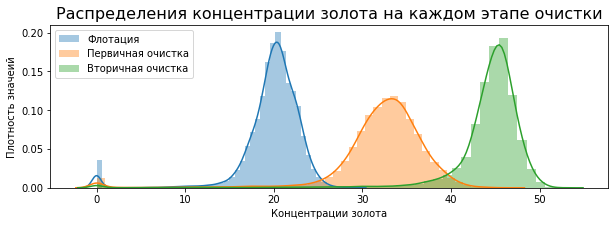

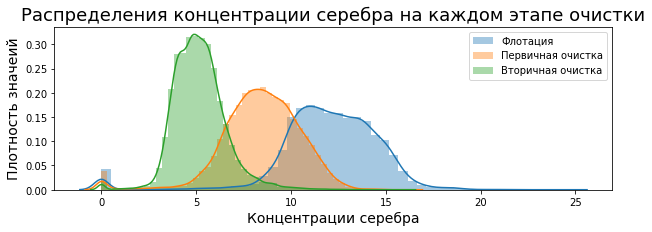

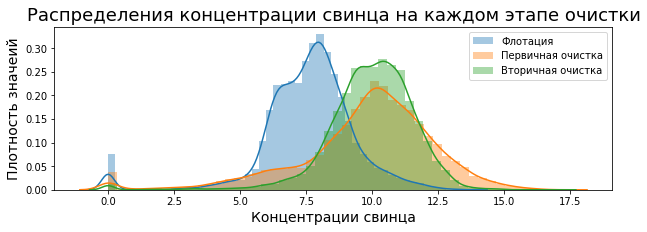

In [148]:
print()
for metal in metals:
    plt.figure(figsize = (10,3))
    for stage in stages:
        ax = sns.distplot(df_full[stage[0] + metal[0]], 
                          label = stage[1])
        plt.legend()
        _ = ax.set(xlabel = 'Концeнтрации ' + metal[1], 
                   ylabel = 'Плотность значеий',
                   title = 'Распределения концентрации ' + metal[1] + ' на каждом этапе очистки')
    plt.rc('axes',
           titlesize = 18)
    plt.rc('axes',
           labelsize = 14)
    plt.show()

#### Содержание металлов на каждом этапе обработки

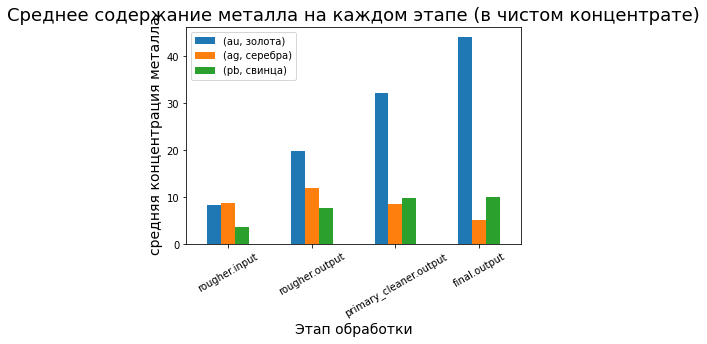

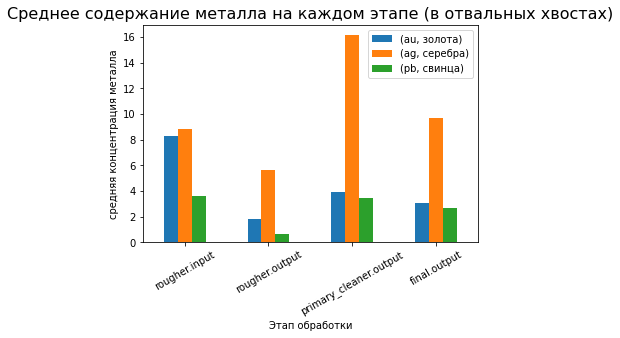

In [149]:
print_bar_metal(df_full)

#### Вывод

    - Концентрация золота повышается с каждым этапом обработки, что и является основной целью процесса.
    - Концентрация серебра понижается с каждым этапом обработки.
    - Концентрация свинца повышается при первичной очистке и не изменяется при вторичной.
    - Интересное содержание металов в отвальных хвостах. Его на выходе чуть больше чем в начале, а после первичной очистки, 
      так и в 2 раза больше исходного.
    

### Распределения размеров гранул сырья на обучающей и тестовой выборках

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

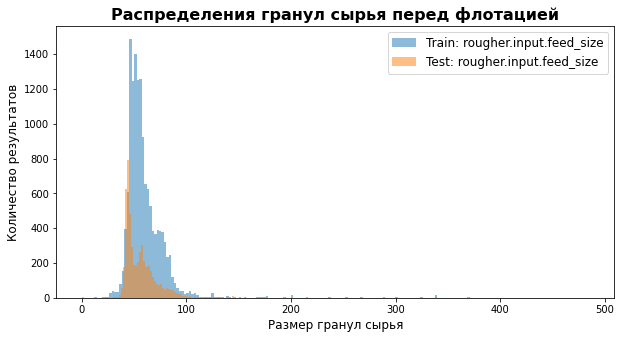

In [150]:
print()
plt.figure(figsize = [10,5])
plt.hist(df_train['rougher.input.feed_size'], 
                    bins = 200, 
                    label = 'Train: rougher.input.feed_size', 
                    alpha = .5)
plt.hist(df_test['rougher.input.feed_size'], 
                    bins = 200, 
                    label = 'Test: rougher.input.feed_size', 
                    alpha = .5)
plt.xlabel("Размер гранул сырья",
           fontsize = 12)
plt.ylabel("Количество результатов",
           fontsize = 12)
plt.legend(loc='upper right',
           fontsize = 12)
plt.title("Распределения гранул сырья перед флотацией",
          fontsize = 16,
          fontweight = 'bold')
plt.show()

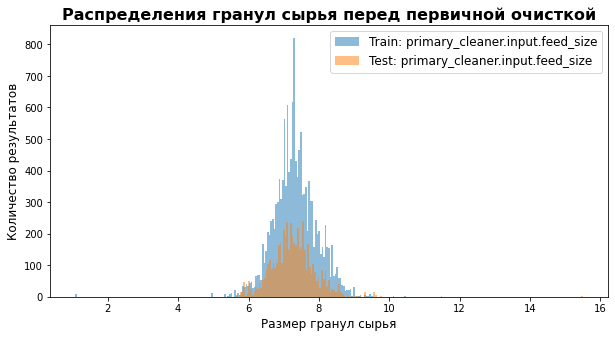

In [151]:
print()
plt.figure(figsize = [10,5])
plt.hist(df_train['primary_cleaner.input.feed_size'], 
         bins = 200, 
         label = 'Train: primary_cleaner.input.feed_size', 
         alpha = .5)
plt.hist(df_test['primary_cleaner.input.feed_size'], 
         bins = 200, 
         label = 'Test: primary_cleaner.input.feed_size', 
         alpha = .5)
plt.xlabel("Размер гранул сырья",
           fontsize = 12)
plt.ylabel("Количество результатов",
           fontsize = 12)
plt.legend(loc='upper right',
           fontsize = 12)
plt.title("Распределения гранул сырья перед первичной очисткой",
          fontsize = 16,
          fontweight = 'bold')
plt.show()

#### Вывод

Распределения размеров гранул сырья до флотации и до первичной очистки в обучающей и тестовой выбрке не сильно отличаются друг от друга. Оценка модели должна получиться правильной.

### Суммарная концентрация всех веществ

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

Посчитаем финальные концентрации.

In [152]:
final_output_concentrate_sum = (df_full['final.output.concentrate_au'] + 
                                df_full['final.output.concentrate_ag'] + 
                                df_full['final.output.concentrate_pb'] +
                                df_full['final.output.concentrate_sol'])
primary_cleaner_output_concentrate_sum = (df_full['primary_cleaner.output.concentrate_au'] + 
                                          df_full['primary_cleaner.output.concentrate_ag'] + 
                                          df_full['primary_cleaner.output.concentrate_pb'] +
                                          df_full['primary_cleaner.output.concentrate_sol'])
rougher_output_concentrate_sum = (df_full['rougher.output.concentrate_au'] + 
                                  df_full['rougher.output.concentrate_ag'] + 
                                  df_full['rougher.output.concentrate_pb'] +
                                  df_full['rougher.output.concentrate_sol'])

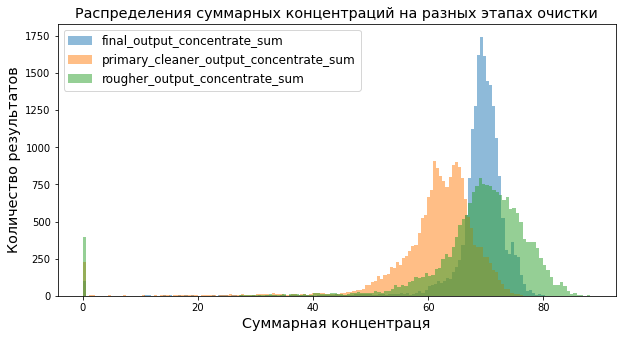

In [154]:
plt.figure(figsize = [10,5])
plt.hist(final_output_concentrate_sum, 
         bins = 150, 
         label = 'final_output_concentrate_sum', 
         alpha = .5)
plt.hist(primary_cleaner_output_concentrate_sum, 
         bins = 150, 
         label = 'primary_cleaner_output_concentrate_sum', 
         alpha = .5)
plt.hist(rougher_output_concentrate_sum, 
         bins = 150, 
         label = 'rougher_output_concentrate_sum', 
         alpha = .5)
plt.xlabel("Суммарная концентраця",
           fontsize = 'x-large')
plt.ylabel("Количество результатов",
           fontsize = 'x-large')
plt.legend(loc = 'upper left',
           fontsize = 'large')
plt.title("Распределения суммарных концентраций на разных этапах очистки",
          fontsize = 'x-large')
plt.show()

#### Вывод

Суммарная концентрация всех веществ меньше после первичной очистки по сравнению с финальной и после флотации.

## Модель

Удаляем из df_train то, чего в  df_test не будет. Количество признаков должно быть одинаковым.

In [155]:
df_train_opt = df_train[df_test.columns]

Лишнее удалили. Восстанавливаем целевые признаки в df_train.

In [156]:
df_train_opt['final.output.recovery'] = df_train['final.output.recovery']
df_train_opt['rougher.output.recovery'] = df_train['rougher.output.recovery']
gr.column_differences(df_train_opt, df_test)

========== Отличающиеся столбцы ==========

1. final.output.recovery
2. rougher.output.recovery

Количество столбцов в df1: 54
Количество столбцов в df2: 52
Общее количество отличающихся столбцов:  2


Обучим разные модели и оценим их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке.

Разобъем данные на признаки и целевой признак.

In [157]:
features_rougher = df_train_opt.drop(['rougher.output.recovery', 
                                      'final.output.recovery'], 
                                       axis = 1)            # Признаки после флотации
features_final = features_rougher                         # Признаки после вторичной очистки
target_rougher = df_train_opt['rougher.output.recovery']  # Целевой признак после флотации
target_final = df_train_opt['final.output.recovery']        # Целевой признак после вторичной очистки

Возьмем для анализа 3 модели:

    - Линейная регрессия, 
    - Решающее дерево, 
    - Случайный лес
и посмотрим у какой модели получется лучше показатель итогового sMAPE.

Укажем какие параметры будем подбирать для GridSearchCV.

In [158]:
random_state = 1980

In [159]:
state = RandomState(random_state)

pipe = Pipeline([
                 ('model', RandomForestRegressor(n_estimators = 10,
                                                 random_state = state))
                 ])

params = [{'imp__strategy': ['mean',
                             'median'],
           'model': [LinearRegression()]
           },
          {'model': [DecisionTreeRegressor(random_state = state)],
           'model__max_depth': [35]
           },
          {'imp__strategy': ['mean',
                             'median'],
           'model': [RandomForestRegressor(n_estimators = 10,
                                           random_state = state)],
           'model__max_features': np.linspace(0.1, 1, 10)
           }
          ]

### Линейная регрессия

In [160]:
%%time
lr_rougher = LinearRegression()
lr_final = LinearRegression()
lr_params = {'normalize':[True,
                          False],
             'copy_X':[True,
                       False]}
final_smape(lr_rougher,
            lr_final, 
            features_rougher,
            target_rougher, 
            features_final,
            target_final, 
            lr_params)
smape_final_lr = final_smape


sMAPE rougher: -12.80%
Лучшие параметры rougher: {'copy_X': True, 'normalize': True}

sMAPE final: -12.25%
Лучшие параметры final: {'copy_X': True, 'normalize': True}

Итоговое sMAPE: -12.38%

CPU times: user 435 ms, sys: 155 ms, total: 589 ms
Wall time: 3.1 s


### Решающее дерево

In [161]:
%%time
# Wall time: 4min 13s

dtr_rougher = DecisionTreeRegressor(random_state = random_state)
dtr_final = DecisionTreeRegressor(random_state = random_state)
dtr_params= {'max_depth': range(1, 35)}    # проверялось до 100
final_smape(dtr_rougher,
            dtr_final, 
            features_rougher,
            target_rougher, 
            features_final,
            target_final, 
            dtr_params)
smape_final_dtr = final_smape


sMAPE rougher: -12.46%
Лучшие параметры rougher: {'max_depth': 1}

sMAPE final: -11.27%
Лучшие параметры final: {'max_depth': 5}

Итоговое sMAPE: -11.57%

CPU times: user 3.98 s, sys: 295 ms, total: 4.27 s
Wall time: 3min 37s


In [162]:
smape_final_dtr

<function __main__.final_smape>

### Случайный лес

In [163]:
%%time
# Wall time: 3min 21s

rfr_rougher = RandomForestRegressor(random_state = random_state)
rfr_final = RandomForestRegressor(random_state = random_state)
rfr_params = {'max_depth': range(1, 11),        # проверялось до 20
                'n_estimators': range(1, 5)}    # проверялось до 5
final_smape(rfr_rougher,
            rfr_final, 
            features_rougher,
            target_rougher, 
            features_final,
            target_final, 
            rfr_params)
smape_final_rfr = final_smape


sMAPE rougher: -13.19%
Лучшие параметры rougher: {'max_depth': 2, 'n_estimators': 1}

sMAPE final: -16.20%
Лучшие параметры final: {'max_depth': 7, 'n_estimators': 1}

Итоговое sMAPE: -15.45%

CPU times: user 4.07 s, sys: 244 ms, total: 4.31 s
Wall time: 2min 50s


### Сводная таблица с результатами

In [164]:
table = {'Модель': ['Линейная регрессия',
                    'Решающее дерево',
                    'Случайный лес'], 
        'Итоговое sMAPE': ['-12.38%', 
                           '-11.57%', 
                           '-15.45%'],
        'Лучшие параметры': ['copy_X: True; normalize: True', 
                             'max_depth: 3', 
                             'max_depth: 2; n_estimators: 3']}
table = pd.DataFrame.from_dict(table)
display(table)

,Модель,Итоговое sMAPE,Лучшие параметры
0,Линейная регрессия,-12.38%,copy_X: True; normalize: True
1,Решающее дерево,-11.57%,max_depth: 3
2,Случайный лес,-15.45%,max_depth: 2; n_estimators: 3


Лучшее значение sMAPЕ оказалось у Модели Случайный лес = -15.45%. Эту модель и будем использовать для теста с параметром "max_depth: 30" для этапа final.

### Тестирование модели

Из df_full возьмем данные для целевого признака, т.к. их не было в тестовой выборке.

In [165]:
target_rougher_test = df_full.loc[df_test.index,'rougher.output.recovery']
target_final_test = df_full.loc[df_test.index,'final.output.recovery']

Признаками для каждого этапа.

In [166]:
features_rougher_test = df_test.loc[target_rougher_test.index]  # признаки для этапа rougher
features_final_test= df_test.loc[target_final_test.index]       # признаки для этапа final

In [167]:
dtr_rougher_test = RandomForestRegressor(random_state = random_state, 
                                         n_estimators = 3, 
                                         max_depth = 2)
dtr_rougher_test.fit(features_rougher, 
                     target_rougher)
predictions_rougher_test = dtr_rougher_test.predict(features_rougher_test)
smape_rougher_test = smape(target_rougher_test,
                           predictions_rougher_test)

dtr_final_test = RandomForestRegressor(random_state = random_state, 
                                       n_estimators = 3, 
                                       max_depth = 2)
dtr_final_test.fit(features_final,
                   target_final)
predictions_final_test = dtr_final_test.predict(features_final_test)
smape_final_test = smape(target_final_test,
                         predictions_final_test)

smape_final_test = 0.25*smape_rougher_test + 0.75*smape_final_test  

print('\nsMAPE rougher: {:.2f}%'. format(smape_rougher_test))
print('\nsMAPE final: {:.2f}%'. format(smape_final_test))
print ('\nИтоговое sMAPE: {:.2f}%\n'. format(smape_final_test))


sMAPE rougher: -14.10%

sMAPE final: -10.48%

Итоговое sMAPE: -10.48%



### Проверка модели на адекватность

In [168]:
dummy = DummyRegressor(strategy = 'median')

dummy.fit(features_rougher,
          target_rougher)
predictions_rougher_test = dummy.predict(features_rougher_test)
smape_rougher_test = smape(target_rougher_test,
                           predictions_rougher_test)
dummy.fit(features_final,
          target_final)
predictions_final_test = dummy.predict(features_final_test)
smape_final_test = smape(target_final_test,
                         predictions_final_test)

smape_dummy = 0.25*smape_rougher_test + 0.75*smape_final_test

print('sMAPE dummy-модели на тестовой выборке: ', smape_dummy)

sMAPE dummy-модели на тестовой выборке:  -9.479919198122863


Результат модели "Решающее дерево" получился лучше, чем у DummyRegressor. Значит построенная модель адекватна.

### Вывод

С помощью метрики качества sMAPE и методов кросс-валидации лучшей моделью оказалась "Случайный лес". Ее sMAPE самое низкое и равно -15.45%.

## Итоговый вывод

Прототип модели машинного обучения был получен. Лучшей оказалась модель "Случайный лес".

Модель предсказывает коэффициент восстановления золота из золотосодержащей руды с погрешностью (симметричное среднее абсолютное процентное отклонение) -15.45% на тренировочных данных и -14.10% на тестовых.

Цели проекта достигнуты:

    - Данные подготовлены.
    - Проведен исследовательский анализ данных:
        - Концентрация золота повышается с каждым этапом обработки.
        - Концентрация серебра понижается с каждым этапом обработки.
        - Концентрация свинца повышается при первичной очистке и не изменяется при вторичной.
        - Интересное содержание металов в отвальных хвостах.
        - Распределения размеров гранул сырья до флотации и до первичной очистки в обучающей и тестовой выбрке не сильно отличаются друг от друга.
        - Суммарная концентрация всех веществ меньше после первичной очистки по сравнению с финальной и после флотации.
    - Построены и обучены 3 модели предсказания. Среди которых выбрана "Решающее дерево".